# Gradient Domain Fusion
The project primary goal is to explore and understand the complexities of gradient-domain processing. This intriguing technique, widely used in digital image processing, focuses on combining multiple images by identifying their gradients and edges to create a high-quality output image.

The allure of this project for me is the potential of gradient-domain processing to radically alter and improve the way we handle and manipulate digital images. By strategically utilizing gradients, which are changes in intensity or color in an image, this technique seamlessly merges multiple images. The resultant output is a superior-quality image that encapsulates the essence of the original inputs, yet boasts an enhanced visual appeal.

---

## 1. Setup env

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy as sp
import scipy.sparse.linalg
from typing import List, Tuple

In [3]:
def get_image(img_path: str, mask: bool=False, scale: bool=True) -> np.array:
    """
    Gets image in appriopiate format
  
    Parameters:
    img_path (str): Image path
    mask (bool): True if read mask image
    scale (bool): True if read and scale image to 0-1
  
    Returns:
    np.array: Image in numpy array
    """
    if mask:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return np.where(binary_mask == 255, 1, 0)
    
    if scale:
        return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0
    
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


def show_images(
    imgs: List[np.array], titles: List[str], figsize: Tuple[int]=(15, 10)
) -> None:
    """
    Show images with tites
  
    Parameters:
    imgs (List): List of images
    titles (List): List of titles
    figsize (Tuple): Figure size 
    """
    idx = 1
    fig = plt.figure(figsize=figsize)

    for img, title in zip(imgs, titles):
        ax = fig.add_subplot(1, len(imgs), idx)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(title)
        idx += 1
    plt.show()

## 2. Image Blending

### 2.1. Poisson Blending
The idea behind Poisson blending [(Perez et al., 2003)](https://cs.brown.edu/courses/csci1950-g/asgn/proj2/resources/PoissonImageEditing.pdf) is to seamlessly combine two images by solving a Poisson equation that enforces continuity and smoothness constraints between the source and target images. It is a widely used technique in image processing that allows for the seamless blending of images without visible artifacts or distortions.

$$\min_{v'} \sum_{i\in M,\ j\in N_i\cap M} ((v'_i - v'_j) - (s_i - s_j))^2 + \sum_{i\in M,\ j\in N_i\cap M^c} ((v'_i - t_j) - (s_i - s_j))^2,$$

In [4]:
def neighbours(i: int, j: int, max_i: int, max_j: int) -> List[Tuple[int, int]]:
    """
    Returns 4-connected neighbours for given pixel point.
    :param i: i-th index position
    :param j: j-th index position
    :param max_i: max possible i-th index position 
    :param max_j: max possible j-th index position 
    """
    pairs = []
    
    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))
    
    return pairs

In [5]:
def poisson_blend(
    img_s: np.ndarray, 
    mask: np.ndarray, 
    img_t: np.ndarray
) -> np.ndarray:
    """
    Returns a Poisson blended image with masked img_s over the img_t.
    :param img_s: the image containing the foreground object
    :param mask: the mask of the foreground object in object_img
    :param img_t: the background image 
    """
    img_s_h, img_s_w = img_s.shape
    
    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)
    
    ys, xs = np.where(mask==1) 
        
    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)
    
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]  
        
        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x] - img_s[n_y][n_x]
            
            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1
    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
    
    img_t_out = img_t.copy()
    
    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]
    
    return np.clip(img_t_out, 0, 1)

In [6]:
bg_img = get_image('samples/BackGround1.jpg')
obj_img = get_image('samples/bottle1.jpg')
mask_img =  get_image('samples/mask1.jpg', mask=True)

In [7]:
blend_img = np.zeros(bg_img.shape)
for b in np.arange(3):
    blend_img[:,:,b] = poisson_blend(obj_img[:,:,b], mask_img, bg_img[:,:,b].copy())

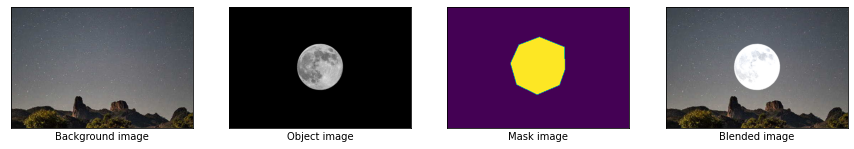

In [8]:
show_images(
    [bg_img, obj_img, mask_img, blend_img], 
    ["Background image", "Object image", "Mask image", "Blended image"]
)

### 2.2. Mixed Gradients
The main difference between Poisson blending and mixed gradient blending is that mixed gradient blending involves blending the gradients of the source and target images directly (Equation 2), potentially resulting in some visible seams or artifacts. But sometimes these artefacts are exactly what we expect to see, for example bricks lines.

$$\min_{v'} \sum_{i\in M,\ j\in N_i\cap M} ((v'_i - v'_j) - g_{ij})^2 + \sum_{i\in M,\ j\in N_i\cap M^c} ((v'_i - t_j) - g_{ij})^2$$

In [91]:
def mixed_blend(
    img_s: np.ndarray, 
    mask: np.ndarray, 
    img_t: np.ndarray
) -> np.ndarray:
    """
    Returns a mixed gradient blended image with masked img_s over the img_t.
    :param img_s: the image containing the foreground object
    :param mask: the mask of the foreground object in img_s
    :param img_t: the background image 
    """
    img_s_h, img_s_w = img_s.shape
    
    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)
    
    ys, xs = np.where(mask==1) 
        
    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)
    
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]  
        
        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            ds = img_s[y][x] - img_s[n_y][n_x]
            dt = img_t[y][x] - img_t[n_y][n_x]
            d = ds if abs(ds) > abs(dt) else dt
            
            A[e, im2var[y][x]] = 1
            b[e] = d
            
            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1
    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
    
    img_t_out = img_t.copy()
    
    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]
    
    return img_t_out #np.clip(img_t_out, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(601, 853, 3) (601, 853, 3) (601, 853)


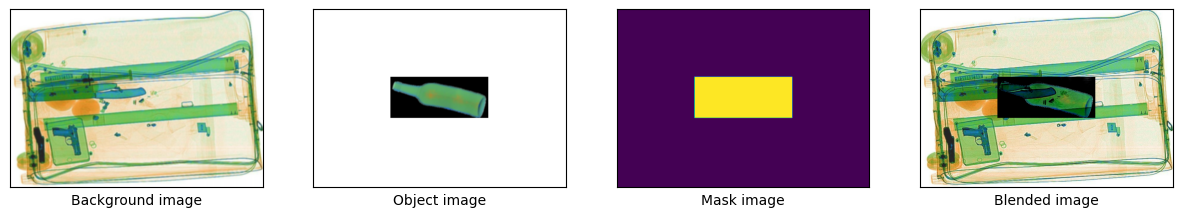

In [128]:
bg_img = get_image('samples/BackGround2.jpg')
obj_img = get_image('samples/bottle1.jpg')
mask_img =  get_image('samples/gun2.jpg', mask=True)

bg_img = cv2.blur(bg_img, (5,5))
obj_img = cv2.blur(obj_img, (5,5))

# bg_img = get_image('samples/img3.jpg')
# obj_img = get_image('samples/img4.jpg')
# mask_img =  get_image('samples/mask2.jpg', mask=True)

bg_img_h, bg_img_w = bg_img.shape[:2]
obj_img_h, obj_img_w = obj_img.shape[:2]

x_offset = (bg_img_w - obj_img_w)//2
y_offset = (bg_img_h - obj_img_h)//2

new_obj_img = np.ones_like(bg_img)
new_obj_img[y_offset:y_offset+obj_img_h, x_offset:x_offset+obj_img_w] = obj_img

new_mask_img = np.zeros_like(bg_img[:,:,0])
print(new_mask_img[0:5, 0:5])
new_mask_img[y_offset:y_offset+obj_img_h, x_offset:x_offset+obj_img_w] = 1
print(bg_img.shape, new_obj_img.shape, new_mask_img.shape)

show_images(
    [bg_img, new_obj_img, new_mask_img, mix_img],
    ["Background image", "Object image", "Mask image", "Blended image"]
)


In [129]:
mix_img = np.zeros(bg_img.shape)
new_obj_img = cv2.cvtColor(new_obj_img.astype('float32'), cv2.COLOR_BGR2HSV)

# shouldn't convert mask into hsv format
bg_img = cv2.cvtColor(bg_img.astype('float32'), cv2.COLOR_BGR2HSV)


for b in np.arange(1,3): # don't use the Hue Channel
    mix_img[:,:,b] = mixed_blend(new_obj_img[:,:,b], new_mask_img, bg_img[:,:,b].copy())

mix_img[:,:, 0] = np.maximum(bg_img[:,:,0], new_obj_img[:,:,0])
mix_img[y_offset:y_offset+obj_img_h, x_offset:x_offset+obj_img_w, 0] \
    = np.minimum(bg_img[y_offset:y_offset+obj_img_h, x_offset:x_offset+obj_img_w, 0], new_obj_img[y_offset:y_offset+obj_img_h, x_offset:x_offset+obj_img_w, 0])

mix_img = cv2.cvtColor(mix_img.astype('float32'), cv2.COLOR_HSV2BGR)
bg_img = cv2.cvtColor(bg_img.astype('float32'), cv2.COLOR_HSV2BGR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


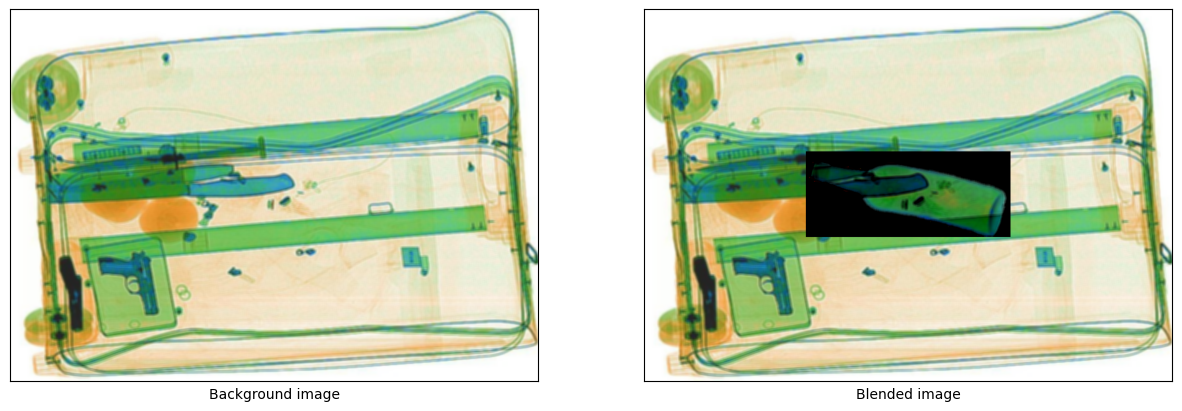

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


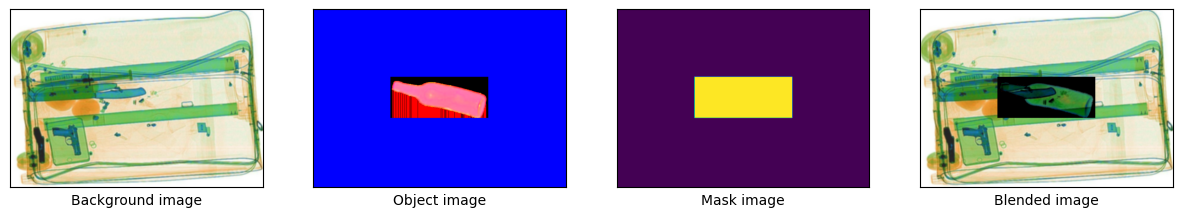

In [130]:
show_images(
    [bg_img,  mix_img],
    ["Background image", "Blended image"]
)

show_images(
    [bg_img, new_obj_img, new_mask_img, mix_img], 
    ["Background image", "Object image", "Mask image", "Blended image"]
)


### 2.3. Laplacian pyramid blending
Laplacian pyramid blending is a technique for blending images that uses a multi-scale representation called a Laplacian pyramid. The pyramid levels are blended using a mask that determines the contribution of each level to the final blended image. The blending starts from the top level, and the result is added to the corresponding level of the blended image pyramid. This process is repeated for each level of the pyramid, resulting in a seamless blend of the source and target images.

In [13]:
def _2d_gaussian(sigma: float) -> np.ndarray:
    """
    Returns 2D Gaussian filter.
    :param sigma: controls the kernel strength
    """
    ksize = np.int(np.ceil(sigma)*6+1)
    gaussian_1d = cv2.getGaussianKernel(ksize, sigma)
    
    return gaussian_1d * np.transpose(gaussian_1d)

def _low_pass_filter(img: np.ndarray, sigma: float) -> np.ndarray:
    """
    Returns low-pass filter.
    :param img: image
    :param sigma: controls the kernel strength
    """
    return cv2.filter2D(img, -1, _2d_gaussian(sigma))

def _high_pass_filter(img: np.ndarray, sigma: float) -> np.ndarray:
    """
    Returns high-pass filter.
    :param img: image
    :param sigma: controls the kernel strength
    """
    return img - _low_pass_filter(img, sigma)

In [14]:
def _gaus_pyramid(img: np.ndarray, depth: int, sigma: int) -> List[np.ndarray]:
    """
    Creates Gaussian pyramid for img.
    :param img: image
    :param depth: depth of the pyramid
    :param sigma: controls the kernel strength
    """
    _im = img.copy()
    
    pyramid = []
    for d in range(depth-1):
        _im = _low_pass_filter(_im.copy(), sigma)
        pyramid.append(_im)
        _im = cv2.pyrDown(_im)
        
    return pyramid 

def _lap_pyramid(img: np.ndarray, depth: int, sigma: int) -> List[np.ndarray]:
    """
    Creates Laplacian pyramid for img.
    :param img: image
    :param depth: depth of the pyramid
    :param sigma: controls the kernel strength
    """
    _im = img.copy()
    
    pyramid = []
    for d in range(depth-1):
        lap = _high_pass_filter(_im.copy(), sigma)
        pyramid.append(lap)
        _im = cv2.pyrDown(_im)
        
    return pyramid 

def _blend(img1: np.ndarray, img2: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Return single image by blending 2 images with mask.
    :param img1: image 1
    :param img1: image 2
    :param mask: mask
    """
    return img1 * mask + img2 * (1.0 - mask)

In [15]:
def laplacian_blend(
    img1: np.ndarray, 
    img2: np.ndarray, 
    mask: np.ndarray, 
    depth: int, 
    sigma: int
) -> np.ndarray:
    """
    Performs blending using Laplacian pyramid.
    :param img1: original image 1
    :param img1: original image 2
    :param mask: original mask
    :param depth: depth of the pyramid
    :param sigma: controls the kernel strength
    """
    mask_gaus_pyramid = _gaus_pyramid(mask, depth, sigma)
    img1_lap_pyramid, img2_lap_pyramid = _lap_pyramid(img1, depth, sigma), _lap_pyramid(img2, depth, sigma)

    blended = [_blend(obj, bg, mask) for obj, bg, mask in zip(img1_lap_pyramid, img2_lap_pyramid, mask_gaus_pyramid)][::-1]
    
    h, w = blended[0].shape[:2]
    
    img1 = cv2.resize(img1, (h, w))
    img2 = cv2.resize(img2, (h, w))
    mask = cv2.resize(mask, (h, w))

    blanded_img = _blend(img1, img2, mask)
    blanded_img = cv2.resize(blanded_img, blended[0].shape[:2])
    
    imgs = []
    for d in range(0, depth-1):
        gaussian_img = _low_pass_filter(blanded_img.copy(), sigma)
        reconstructed_img = cv2.add(blended[d], gaussian_img)
        
        imgs.append(reconstructed_img)
        blanded_img = cv2.pyrUp(reconstructed_img)
        
    return np.clip(imgs[-1], 0, 1)

In [16]:
img1 = get_image('samples/img9.jpg')
img2 = get_image('samples/img6.jpg')
mask = get_image('samples/mask3.jpg', mask=True)

mask_stack = np.stack((mask.astype(float),)*3, axis=-1)

In [17]:
lap_blend = laplacian_blend(img1, img2, mask_stack, 5, 25)

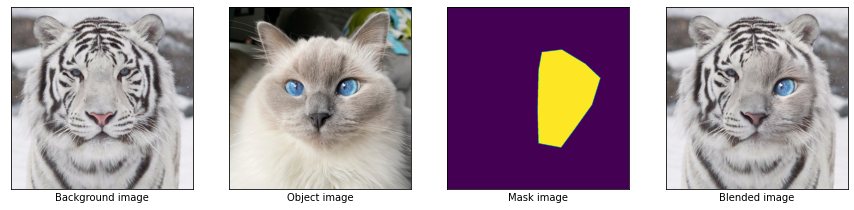

In [18]:
show_images(
    [img2, img1, mask, lap_blend], 
    ["Background image", "Object image", "Mask image", "Blended image"]
)

## 3. Image Enhancement

### 3.1. Poisson Color2Gray
The color2gray gradient-based algorithm converts a color image into a grayscale image by computing the gradient magnitude of the color image and using it to modify the initial grayscale image. The process starts by converting the color image into a grayscale image using a standard luminance conversion formula. Next, the gradient magnitude of the color image is computed using an average of RGB channels values. The resulting gradient magnitude image is then used to modify the initial grayscale image by adjusting the intensity of the pixels in a way that preserves the edges and details of the original color image. Finally, the modified gradient image is added to the initial grayscale image to obtain the final color2gray gradient-based
conversion.

In [19]:
def rgb2gray(rgb: np.array) -> np.array:
    """
    Returns gray image
    :param img: RGB image
    """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [20]:
def color2gray(img: np.ndarray) -> np.ndarray:
    """
    Returns gray image with preserved gradients.
    :param img: RGB image
    """
    img_h, img_w = img.shape[:2]
    img_s = img.copy()
    img_t = rgb2gray(img.copy())
    
    im2var = np.arange(img_h * img_w).reshape(img_h, img_w) 
    
    A = sp.sparse.lil_matrix((img_h*img_w*4, img_h*img_w))
    b = np.zeros(img_h*img_w*4)
    
    e = 0
    for y in range(img_h):
        for x in range(img_w):
            dr = abs(img_s[y][x][0])
            dg = abs(img_s[y][x][1])
            db = abs(img_s[y][x][2])
            
            A[e, im2var[y][x]] = 1
            b[e] = sum([img_s[y][x][n] for n in range(3)]) / 3
            e += 1
                    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
    
    return v.reshape(img_h, img_w) 

In [21]:
color_blind_img = get_image('samples/img5.jpg', scale=False)

In [22]:
color2gray_img = color2gray(color_blind_img)

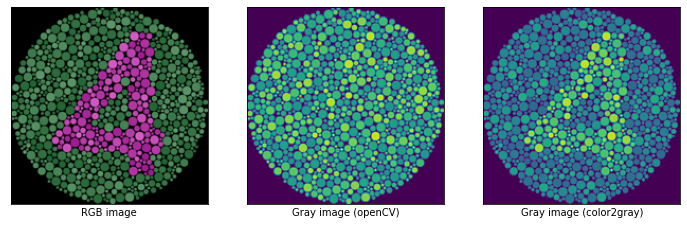

In [23]:
show_images(
    [color_blind_img, cv2.cvtColor(color_blind_img, cv2.COLOR_BGR2GRAY), color2gray_img], 
    ["RGB image", "Gray image (openCV)", "Gray image (color2gray)"], 
    figsize=(12, 8)
)

### 3.2. Poisson Sharpening
The goal of image sharpening is to increase the change in pixel values at the edges. The method is derived fromthe Poisson equation.

$$\min_{v'} \sum_{i} (v'_i - s_i)^2 + \sum_{i,\ j\in N_i} ((v'_i - v'_j) - \alpha(s_i - s_j))^2$$

In [24]:
def poisson_sharpening(
    img: np.ndarray, 
    alpha: int
) -> np.ndarray:
    """
    Returns a shapren image with strenght of alpha.
    :param img: the image
    :param alpha: edge threshold and gradient scaler
    """
    img_h, img_w = img.shape[:2]
    img_s = img.copy()
    
    im2var = np.arange(img_h * img_w).reshape(img_h, img_w) 
    
    A = sp.sparse.lil_matrix((img_h*img_w*4*2, img_h*img_w))
    b = np.zeros(img_h*img_w*4*2)
    
    e = 0
    for y in range(img_h):
        for x in range(img_w):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x]
            e += 1
            
            for n_y, n_x in neighbours(y, x, img_h-1, img_w-1):
                A[e, im2var[y][x]] = 1
                A[e, im2var[n_y][n_x]] = -1
                
                b[e] = alpha * (img_s[y][x] - img_s[n_y][n_x])
                e += 1
                
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]

    return np.clip(v.reshape(img_h, img_w), 0, 1)

In [25]:
img = get_image('samples/img6.jpg')

In [26]:
alpha = 9.0

sharpen_img = np.zeros(img.shape)
for b in np.arange(3):
    sharpen_img[:,:,b] = poisson_sharpening(img[:,:,b], alpha)

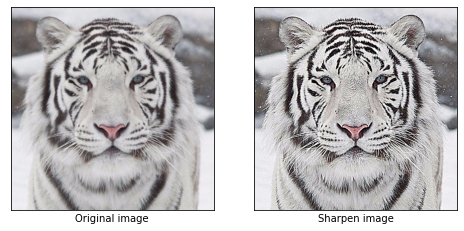

In [27]:
show_images(
    [img, sharpen_img], 
    ["Original image", "Sharpen image"], 
    figsize=(8, 8)
)

### 3.3. Poisson Color Transfer
The goal of the color transfer is to mimic color style on source image into a target image, but still maintain its
gradients. This method is also derived from the Poisson equation.

$$\min_{v'} \sum_{i,\ n\in RGB} (v'_i - \alpha(t_i - avg(t_n) * \frac{std(t_n)}{std(s_n)} + avg(s_n)))^2 + \sum_{i,\ j\in N_i} ((v'_i - v'_j) - (s_i - s_j))^2$$

In [28]:
def color_transfer(
    img_s: np.ndarray, 
    img_t: np.ndarray,
    alpha: int
) -> np.ndarray:
    """
    Returns img_t with color of img_s and strenght of alpha.
    :param img_s: the source image with color style
    :param img_t: the target image to transfer color to
    :param alpha: edge threshold and gradient scaler
    """
    img_t_h, img_t_w = img_t.shape[:2]
        
    im2var = np.arange(img_t_h * img_t_w * 3).reshape((img_t_h, img_t_w, 3)) 
    
    A = sp.sparse.lil_matrix((img_t_h*img_t_w*3*5, img_t_h*img_t_w*3))
    b = np.zeros(img_t_h*img_t_w*3*5)
    
    e = 0
    for n in range(3):
        img_s_channel_avg = np.mean(img_s[:,:,n])
        img_s_channel_std = np.std(img_s[:,:,n])
        img_t_channel_avg = np.mean(img_t[:,:,n])
        img_t_channel_std = np.std(img_t[:,:,n])
        
        for y in range(img_t_h):
            for x in range(img_t_w):
                A[e, im2var[y][x][n]] = 1

                b[e] = img_t[y][x][n] - (img_t_channel_avg * (img_t_channel_std / img_s_channel_std) - img_s_channel_avg) * alpha
                e += 1
                
                for n_y, n_x in neighbours(y, x, img_t_h-1, img_t_w-1):
                    A[e, im2var[y][x][n]] = 1
                    A[e, im2var[n_y][n_x][n]] = -1
                    b[e] = img_t[y][x][n] - img_t[n_y][n_x][n]
                    e += 1
    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
      
    return np.clip(v.reshape((img_t_h, img_t_w, 3)), 0, 1)

In [29]:
style_img = get_image('samples/img7.jpg')
target_img = get_image('samples/img8.jpg')

In [30]:
alpha = 0.5

colored_img = color_transfer(style_img, target_img, alpha)

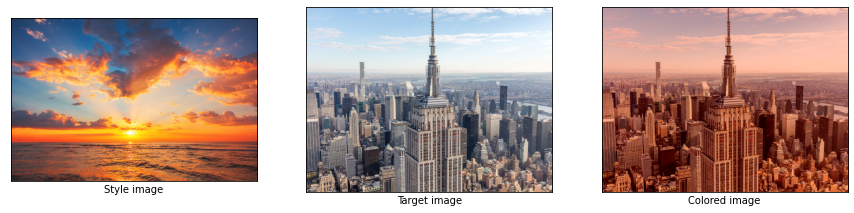

In [31]:
show_images(
    [style_img, target_img, colored_img], 
    ["Style image", "Target image", "Colored image"], 
    figsize=(15, 8)
)

## 4. References
<a id="1">[1]</a> 
Patrick Perez, Michel Gangnet, and Andrew Blake (2003). 
Poisson image editing.
Communications of the ACM, 313–318.